In [1]:
################################################################################
#######################    Time series decomposition    ########################
################################################################################
### Load necessary modules -------------------------------
from dateutil.parser import parse 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import numpy as np
import ForecastingTools as FT
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
import RegressionTools as RT
import neuralsens as ns

In [2]:
# Import data
df = pd.read_excel('DAILY_DEMAND_TR.xlsx', parse_dates=['fecha'], index_col='fecha')
df.head()

DEM        WD    TEMP
fecha                                   
2007-07-01  590.803564  0.803491  23.100
2007-07-02  738.568372  0.971186  22.650
2007-07-03  774.875745  0.997175  23.275
2007-07-04  783.546441  0.999890  24.375
2007-07-05  771.248135  0.998786  21.675

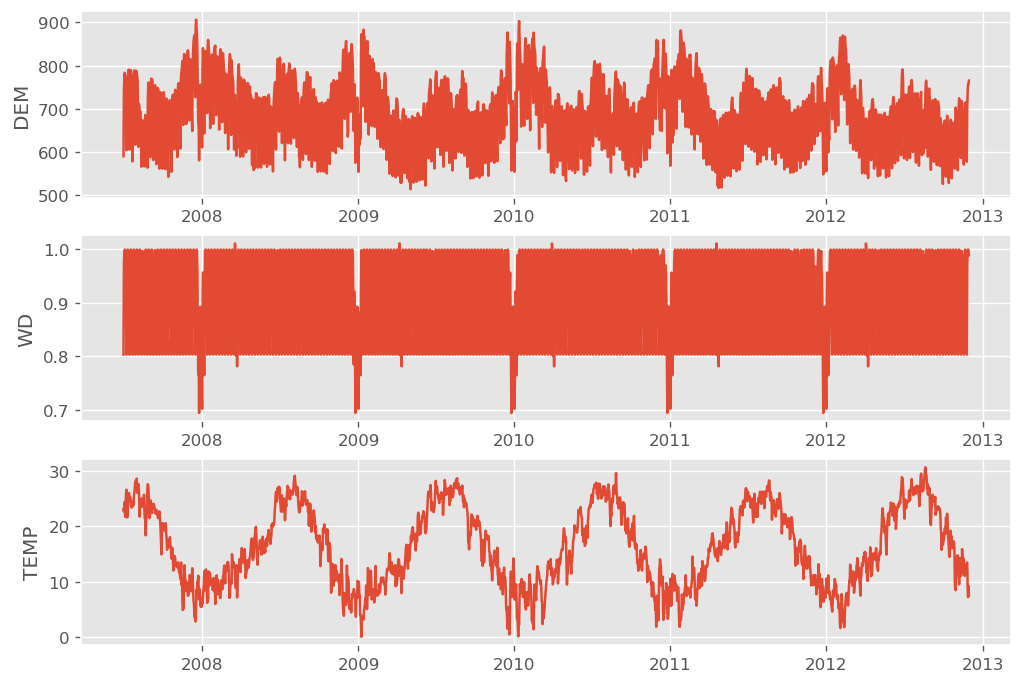

In [3]:
# Plotting a time series
fig, axes = plt.subplots(3, 1)
count = 0
for ax in axes.ravel():
    ax.plot(df.columns.values.tolist()[count], data=df)
    ax.set_ylabel(df.columns.values.tolist()[count])
    count += 1
plt.show()

In [4]:
X = df.loc[:, [name not in ['fecha','DEM'] for name in df.columns.values.tolist()]]
y = df['DEM']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['DEM'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['DEM'] = y_test

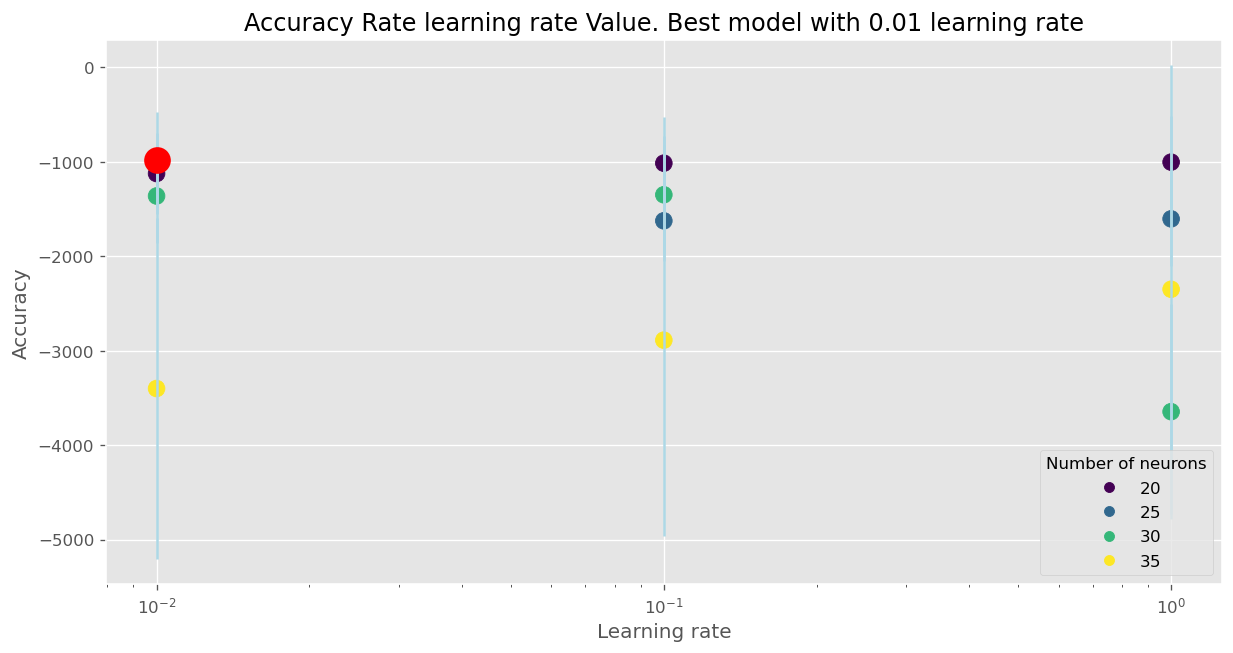

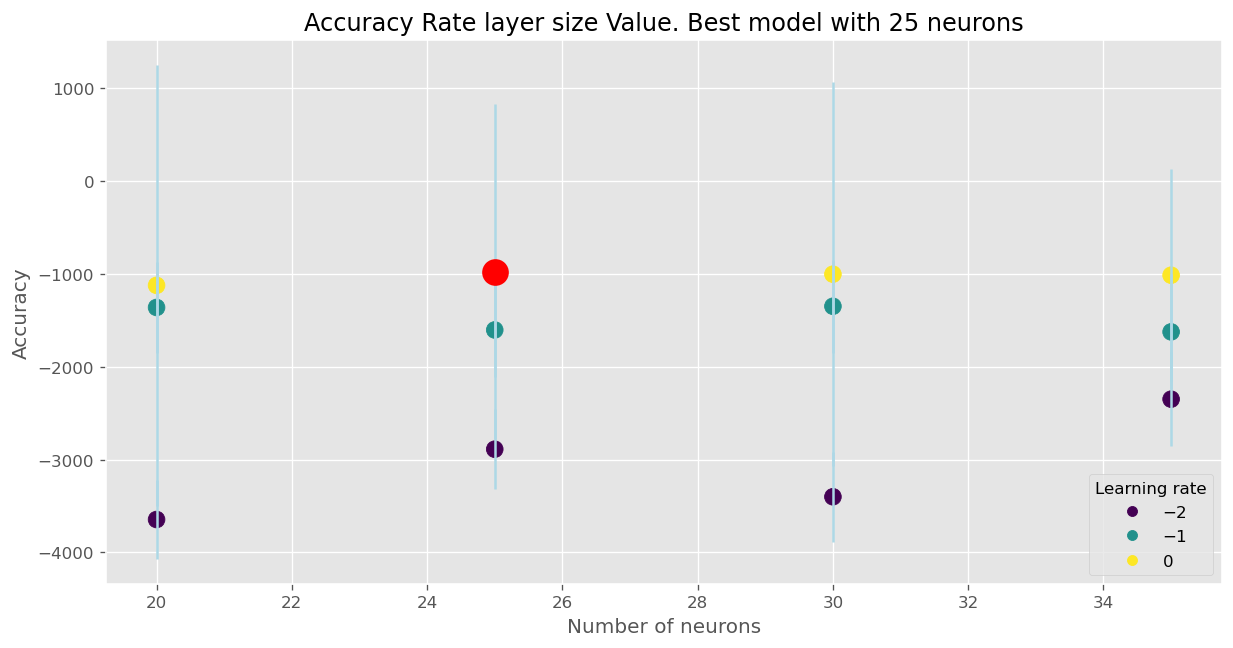

In [5]:
#-------------------------------------------------------------------------------------------------
#--------------------------------------- MLP MODEL -----------------------------------------------
#-------------------------------------------------------------------------------------------------
# Prepare the numeric variables by imputing by its median and scaling
# numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Prepare the categorical variables by imputing by last value and encoding the categories
categorical_features = X_train.select_dtypes(include=['category']).columns.values.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

param = {'MLP__learning_rate_init': [0.01,0.1,1], # Initial value of learning rate 
         'MLP__hidden_layer_sizes':[(20,),(25,),(30,),(35,),]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('MLP', MLPRegressor(solver='adam', # Update function
                                activation='logistic', # Logistic sigmoid activation function
                                alpha=0.01, # L2 regularization term
                                learning_rate='adaptive', # Type of learning rate used in training
                                max_iter=250, # Maximum number of iterations
                                batch_size=10, # Size of batch when training
                                tol=1e-4, # Tolerance for the optimization
                                validation_fraction=0.0, # Percentage of samples used for validation
                                n_iter_no_change=10, # Maximum number of epochs to not meet tol improvement
                                random_state=150))
        ])
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[numeric_features + categorical_features], y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(MLP_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = MLP_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_MLP = meanAcc # Store cv-scores for later



plt.figure(figsize=(12, 6))
plt.errorbar(MLP_fit.cv_results_['param_MLP__learning_rate_init'], 
             [x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(MLP_fit.cv_results_['param_MLP__learning_rate_init'], 
            [x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
            c=[a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Number of neurons")
plt.plot(MLP_fit.best_params_['MLP__learning_rate_init'], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate learning rate Value. Best model with ' + str(MLP_fit.best_params_['MLP__learning_rate_init']) + ' learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

plt.figure(figsize=(12, 6))
plt.errorbar([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
             [x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
             yerr=[x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
            [x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
            c=np.log10(np.array([a for a in MLP_fit.cv_results_['param_MLP__learning_rate_init']],dtype=float)),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Learning rate")
plt.plot(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate layer size Value. Best model with ' + str(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0]) + ' neurons')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.show()

In [6]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = X_train.columns.values.tolist()
X = pd.DataFrame(X, columns=coefnames)
y = y_train
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [7]:
sensmlp = ns.SensAnalysisMLP(wts, bias, actfunc, X, y)

In [8]:
sensmlp.summary()

Sensitivity analysis of [2, 25, 1] MLP network.

Sensitivity measures of each output:

$D 

           mean        std  mean_squared
WD    54.588763  52.673139   5754.392609
TEMP -28.222239  68.944973   5549.904043


In [9]:
sensmlp.info()

Sensitivity analysis of [2, 25, 1] MLP network.

1584 samples

Sensitivities of each output (only 5 first samples):

$D 

           WD        TEMP
0   40.866401  111.040504
1   30.400842  117.629689
2  104.138028   92.421559
3  103.019850   39.371579
4  104.454859   86.581196


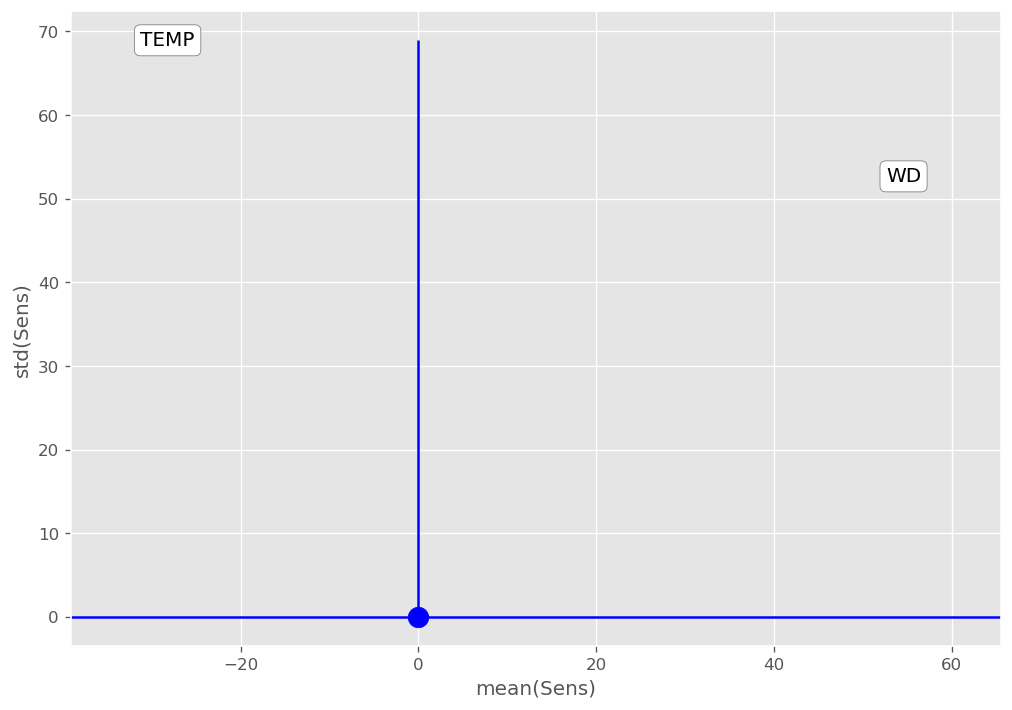

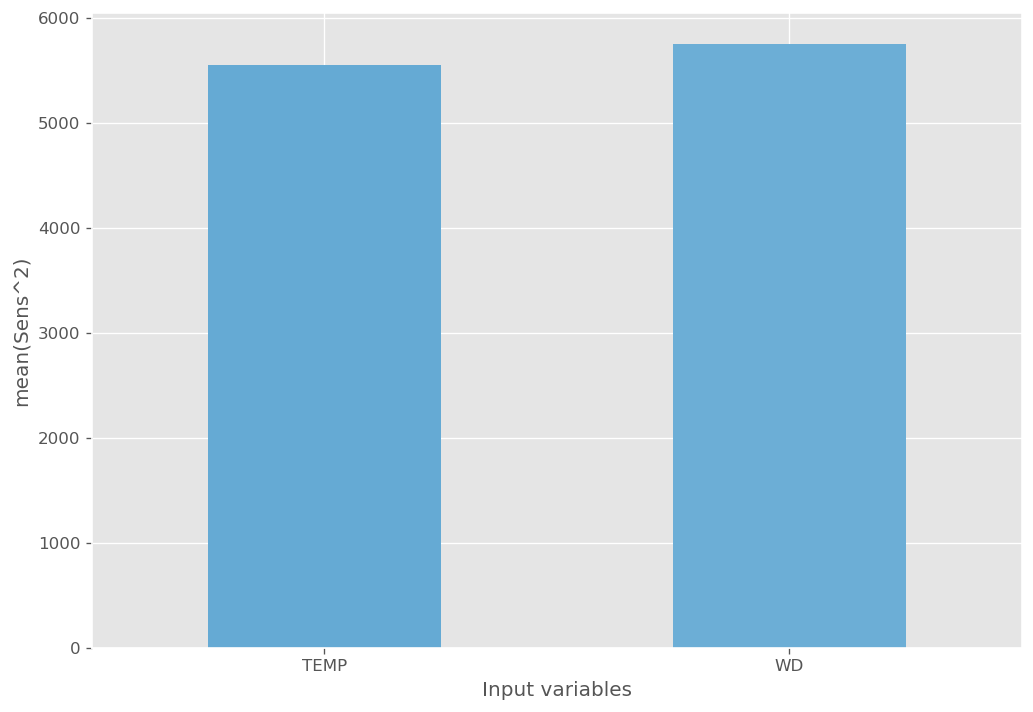

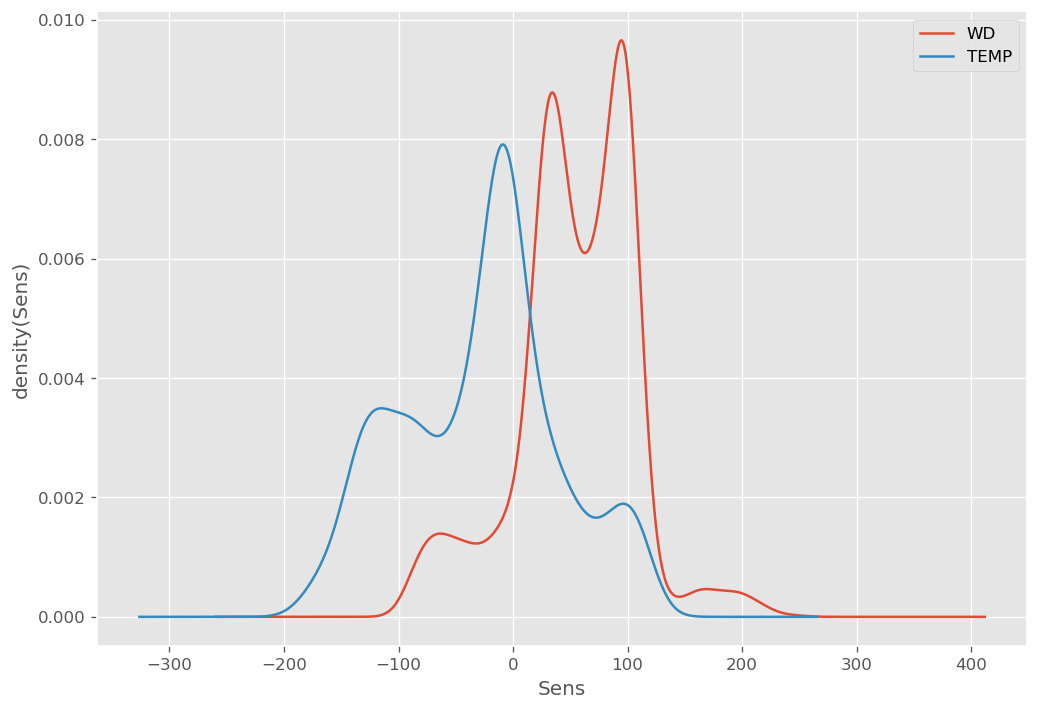

In [10]:
sensmlp.plot()

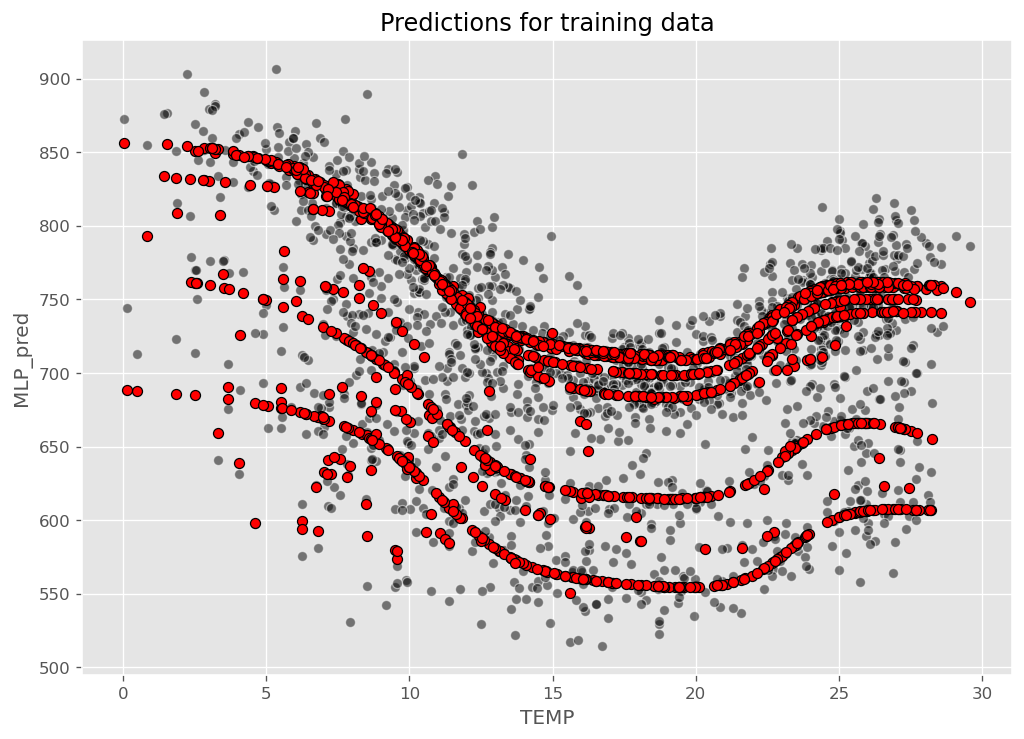

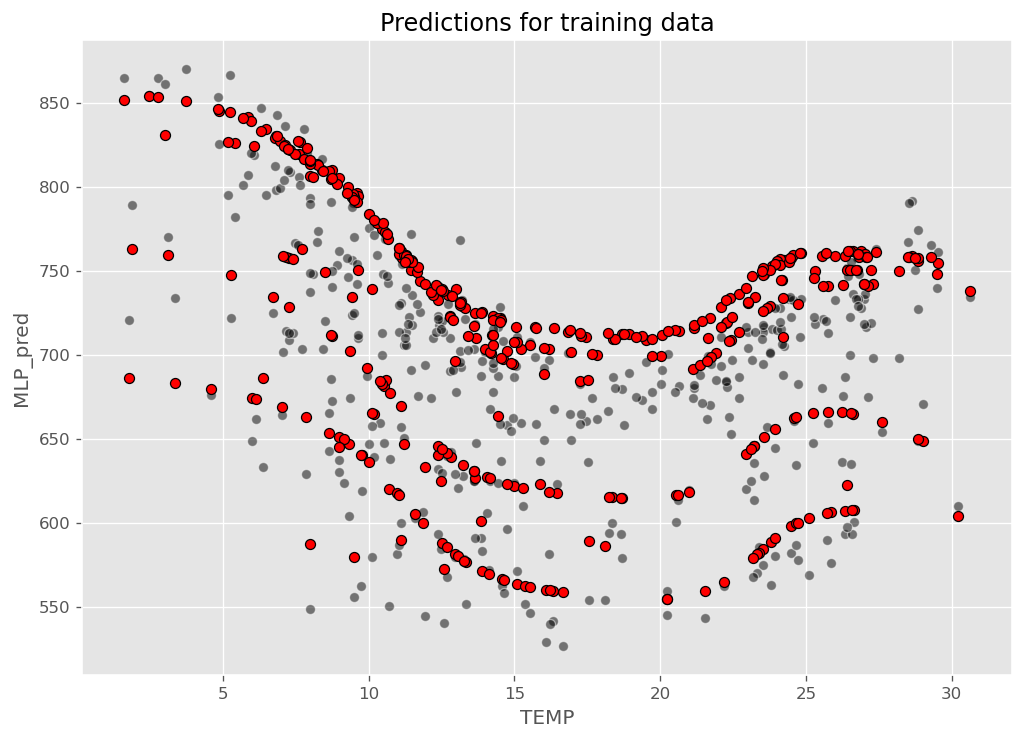

In [11]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

### Plot predictions of the model
sns.scatterplot(x='TEMP', y='DEM', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TEMP', y='DEM', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

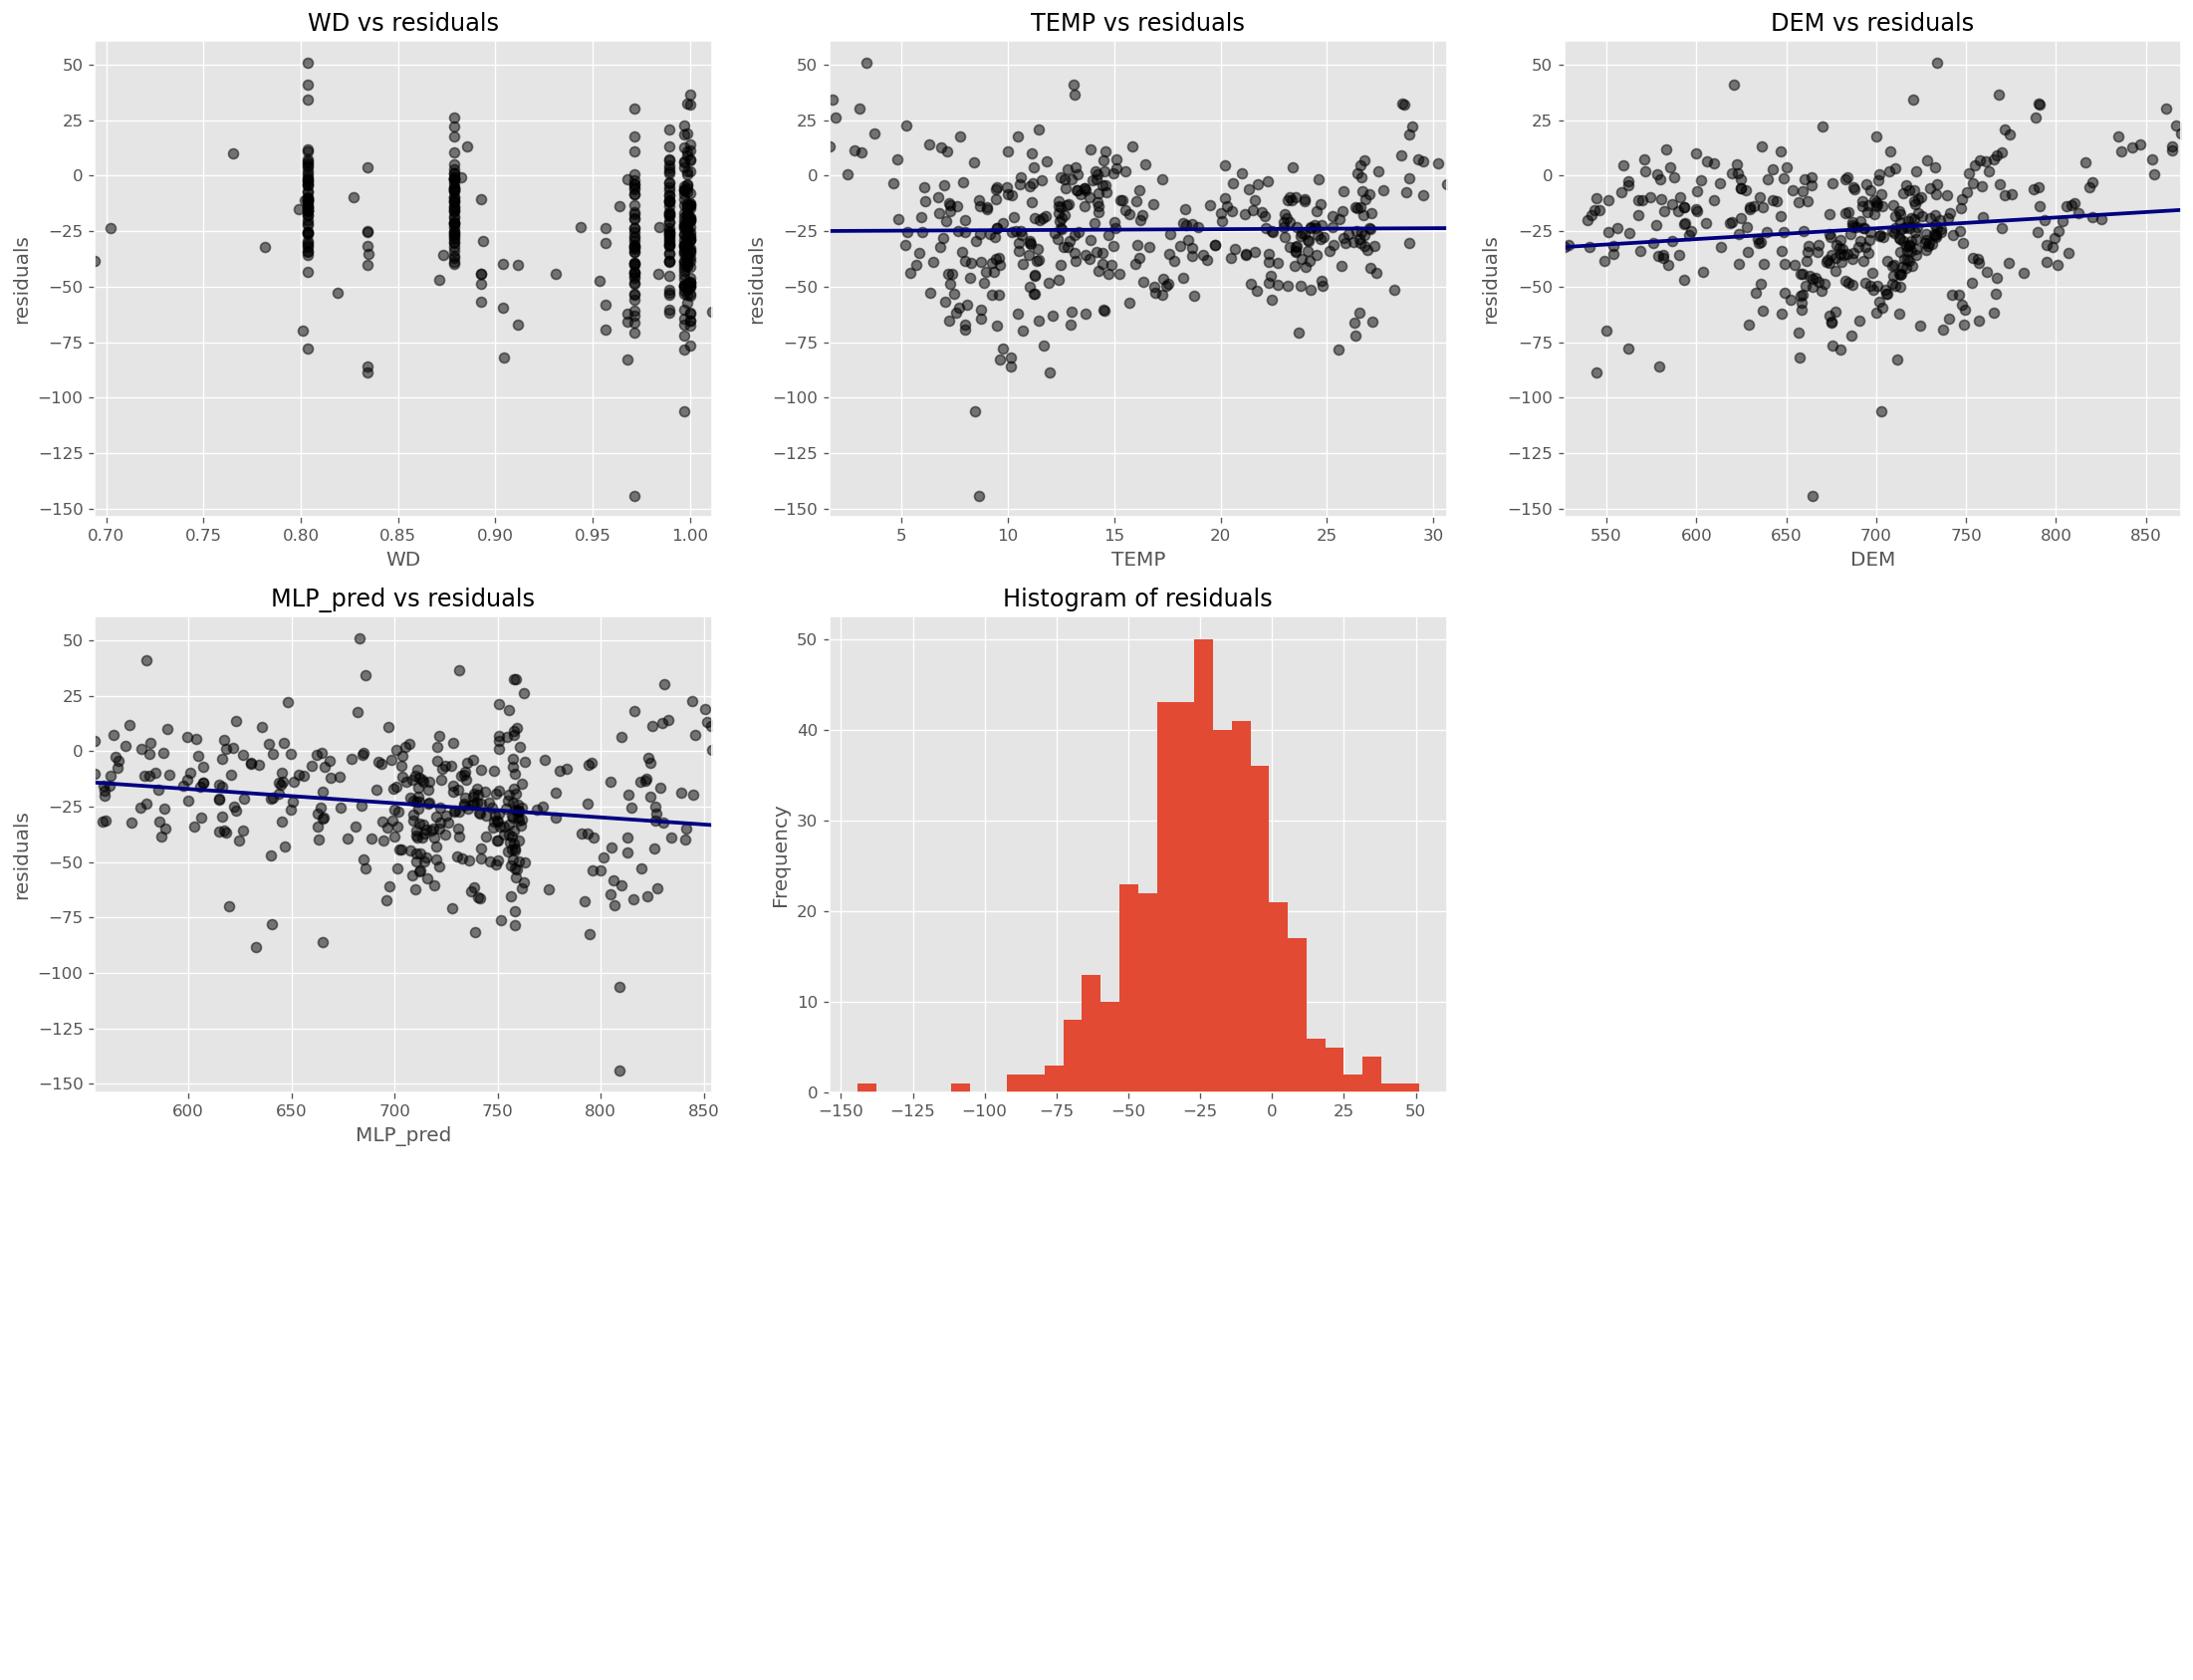

In [12]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTS_eval, 'MLP_pred', 'DEM', spline_degree=1)

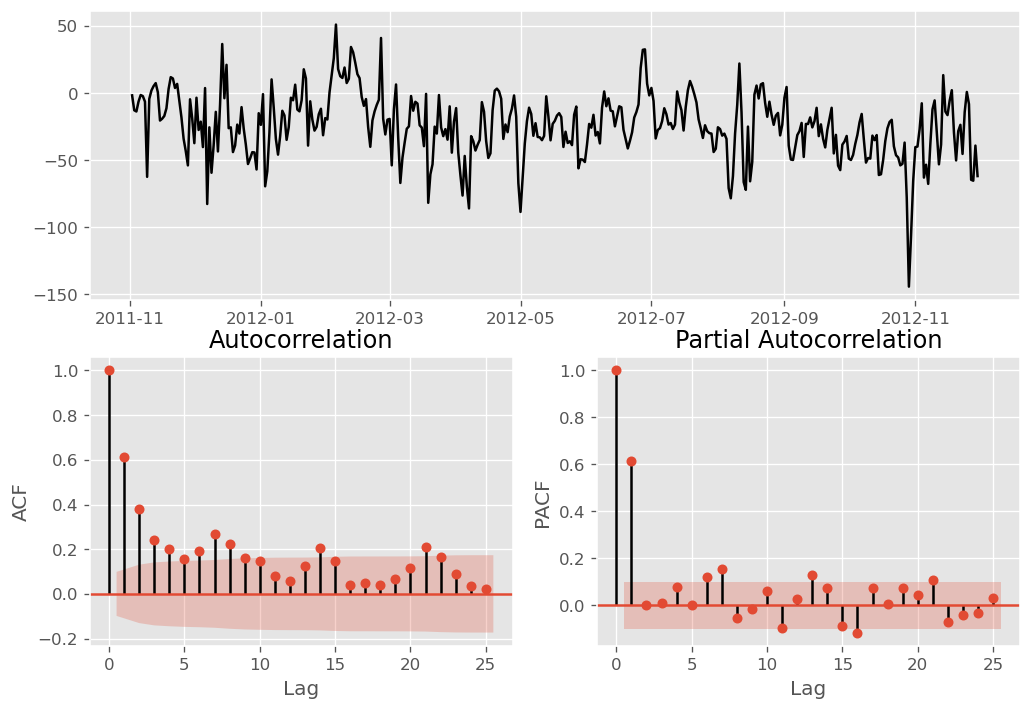

In [13]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['DEM'] - dfTS_eval['MLP_pred'])

In [14]:
###Include lagged variables
df['WD_lag1'] = df['WD'].shift()
df['TEMP_lag1'] = df['TEMP'].shift()
df['DEM_lag1'] = df['DEM'].shift()
df['DEM_lag2'] = df['DEM'].shift(2)

# Remove first NaN rows
df = df.iloc[2:]

In [15]:
X = df.loc[:, [name not in ['fecha','DEM'] for name in df.columns.values.tolist()]]
y = df['DEM']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['DEM'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['DEM'] = y_test

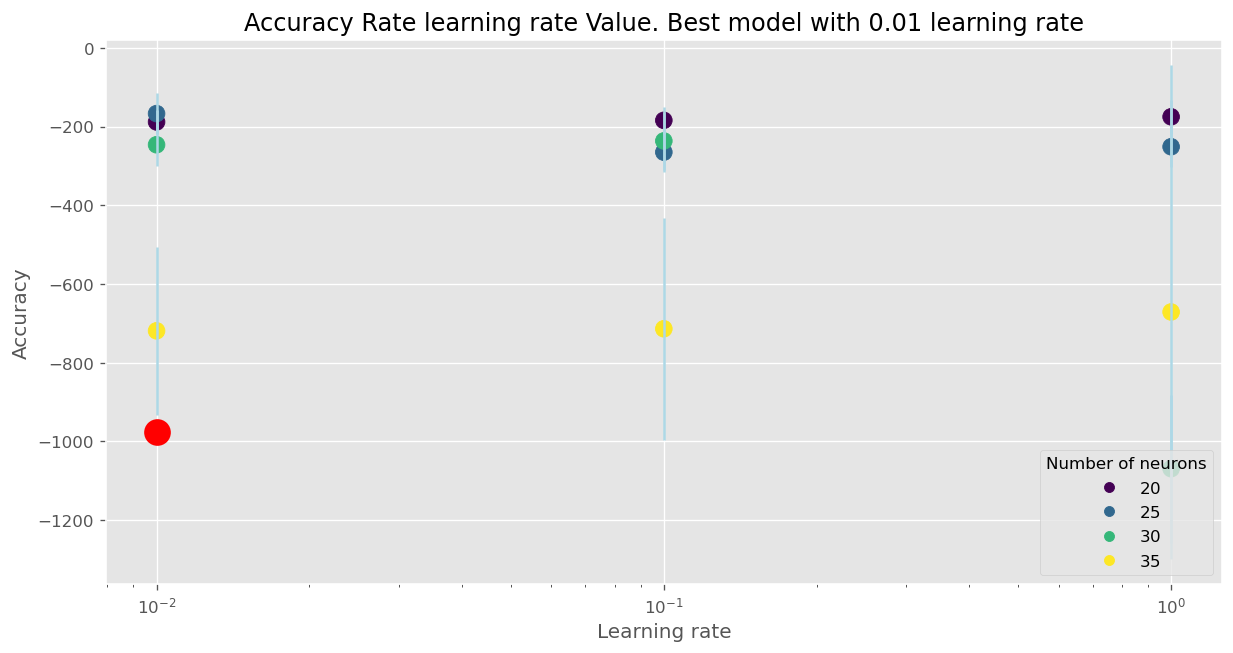

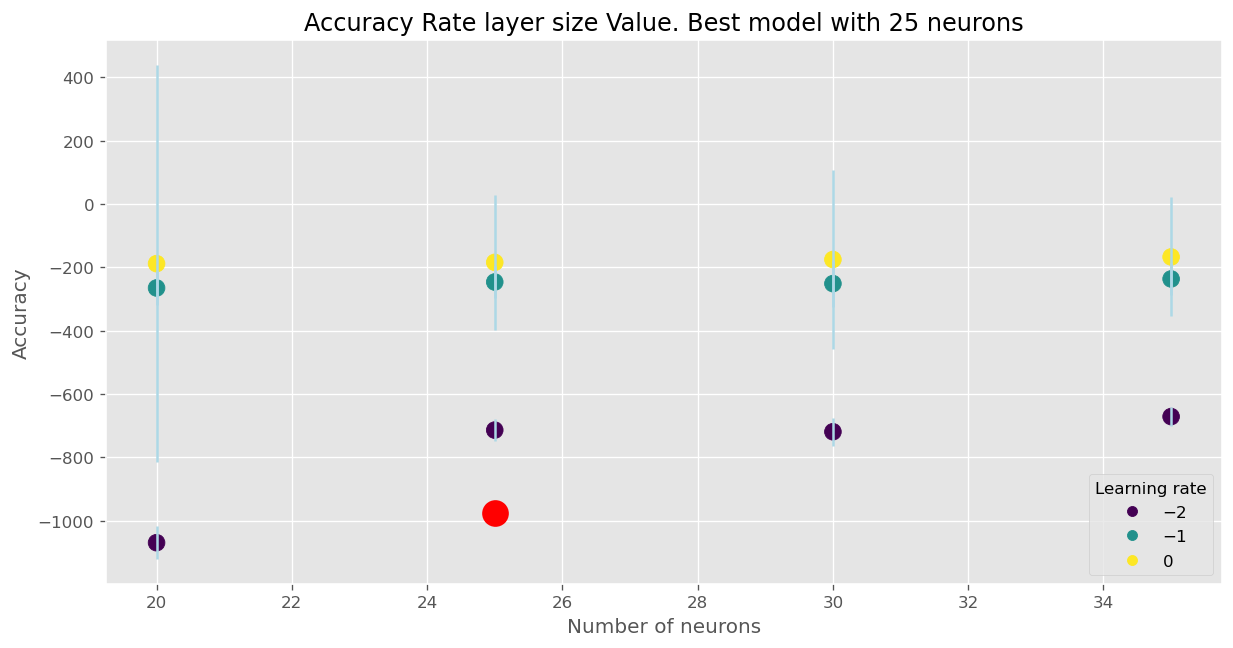

In [16]:
#-------------------------------------------------------------------------------------------------
#--------------------------------------- MLP MODEL -----------------------------------------------
#-------------------------------------------------------------------------------------------------
# Prepare the numeric variables by imputing by its median and scaling
# numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Prepare the categorical variables by imputing by last value and encoding the categories
categorical_features = X_train.select_dtypes(include=['category']).columns.values.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

param = {'MLP__learning_rate_init': [0.01,0.1,1], # Initial value of learning rate 
         'MLP__hidden_layer_sizes':[(20,),(25,),(30,),(35,),]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('MLP', MLPRegressor(solver='adam', # Update function
                                activation='logistic', # Logistic sigmoid activation function
                                alpha=0.01, # L2 regularization term
                                learning_rate='adaptive', # Type of learning rate used in training
                                max_iter=250, # Maximum number of iterations
                                batch_size=10, # Size of batch when training
                                tol=1e-4, # Tolerance for the optimization
                                validation_fraction=0.0, # Percentage of samples used for validation
                                n_iter_no_change=10, # Maximum number of epochs to not meet tol improvement
                                random_state=150))
        ])
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_lagged_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_lagged_fit.fit(X_train[numeric_features + categorical_features], y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(MLP_lagged_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = MLP_lagged_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_MLP = meanAcc # Store cv-scores for later



plt.figure(figsize=(12, 6))
plt.errorbar(MLP_lagged_fit.cv_results_['param_MLP__learning_rate_init'], 
             [x for _,x in sorted(zip(MLP_lagged_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(MLP_lagged_fit.cv_results_['param_MLP__learning_rate_init'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(MLP_lagged_fit.cv_results_['param_MLP__learning_rate_init'], 
            [x for _,x in sorted(zip(MLP_lagged_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
            c=[a[0] for a in MLP_lagged_fit.cv_results_['param_MLP__hidden_layer_sizes']],s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Number of neurons")
plt.plot(MLP_fit.best_params_['MLP__learning_rate_init'], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate learning rate Value. Best model with ' + str(MLP_fit.best_params_['MLP__learning_rate_init']) + ' learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

plt.figure(figsize=(12, 6))
plt.errorbar([a[0] for a in MLP_lagged_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
             [x for _,x in sorted(zip([a[0] for a in MLP_lagged_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
             yerr=[x for _,x in sorted(zip([a[0] for a in MLP_lagged_fit.cv_results_['param_MLP__hidden_layer_sizes']],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter([a[0] for a in MLP_lagged_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
            [x for _,x in sorted(zip([a[0] for a in MLP_lagged_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
            c=np.log10(np.array([a for a in MLP_lagged_fit.cv_results_['param_MLP__learning_rate_init']],dtype=float)),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Learning rate")
plt.plot(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate layer size Value. Best model with ' + str(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0]) + ' neurons')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
mlp = MLP_lagged_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_lagged_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_lagged_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = X_train.columns.values.tolist()
X = pd.DataFrame(X, columns=coefnames)
y = y_train
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [20]:
sensmlp = ns.SensAnalysisMLP(wts, bias, actfunc, X, y)

In [21]:
sensmlp.summary()

Sensitivity analysis of [6, 35, 1] MLP network.

Sensitivity measures of each output:

$D 

                mean        std  mean_squared
WD         56.173692  12.417670   3309.682233
TEMP        1.172460  23.158728    537.701347
WD_lag1   -55.186119  11.115525   3169.062584
TEMP_lag1  -7.301032  12.269909    203.855742
DEM_lag1   72.300759  14.064346   5425.205630
DEM_lag2   -4.788408   7.532117     79.661633


In [22]:
sensmlp.info()

Sensitivity analysis of [6, 35, 1] MLP network.

1582 samples

Sensitivities of each output (only 5 first samples):

$D 

          WD       TEMP    WD_lag1  TEMP_lag1   DEM_lag1   DEM_lag2
0  64.600492  22.296516 -58.223960 -19.987148  69.455392   7.960012
1  64.388575  21.550872 -63.580789 -14.512245  76.757718  -6.191933
2  65.802588  27.868040 -73.978459 -19.050653  91.244268 -13.921013
3  57.753721  27.894098 -63.631628 -17.499995  78.965483 -11.615638
4  57.614651  15.799340 -48.671784  -9.412486  61.976591   2.988092


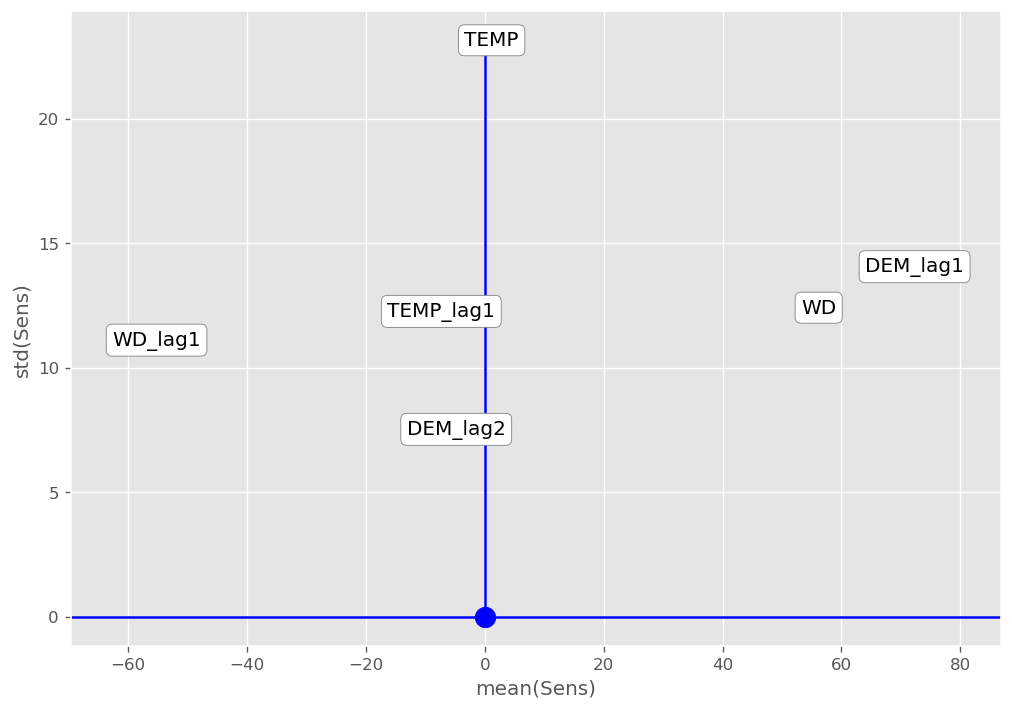

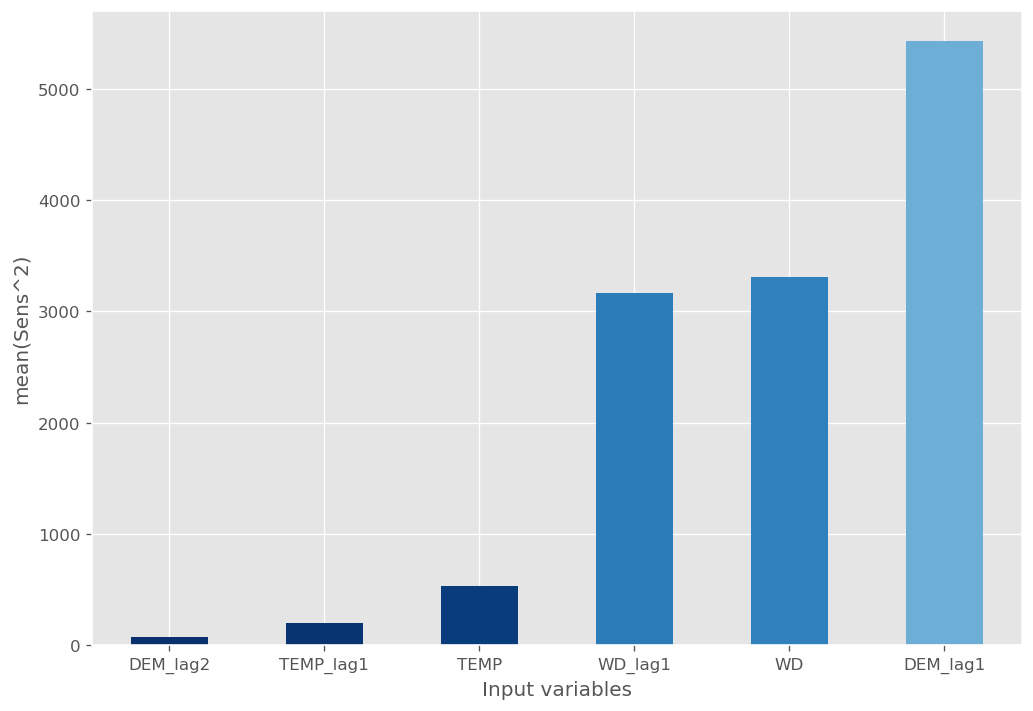

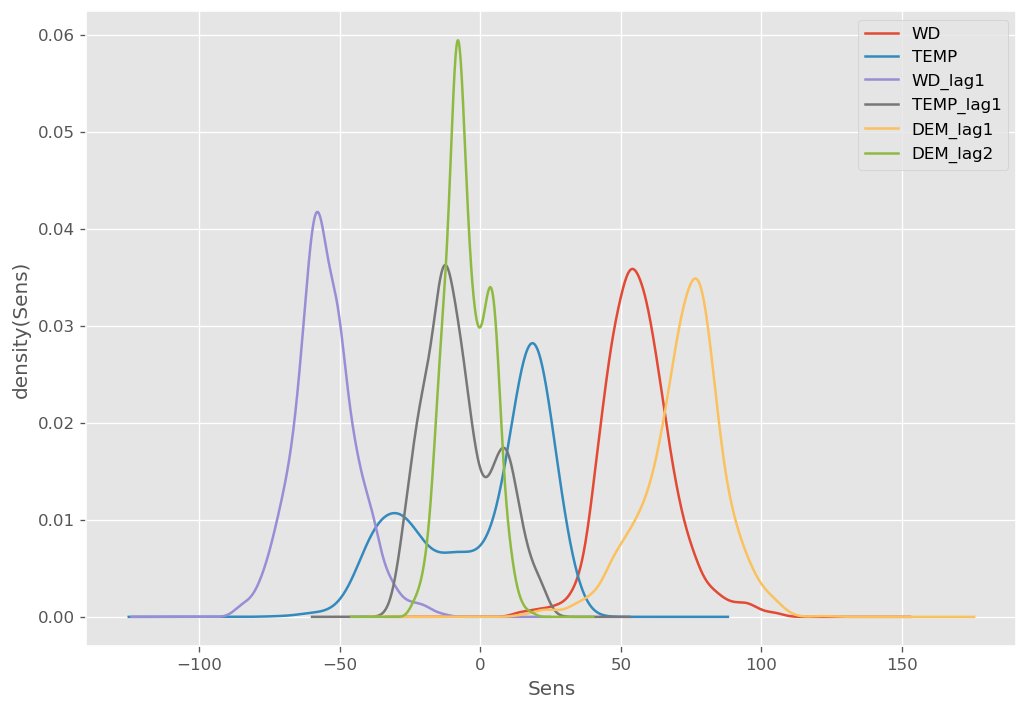

In [23]:
sensmlp.plot()

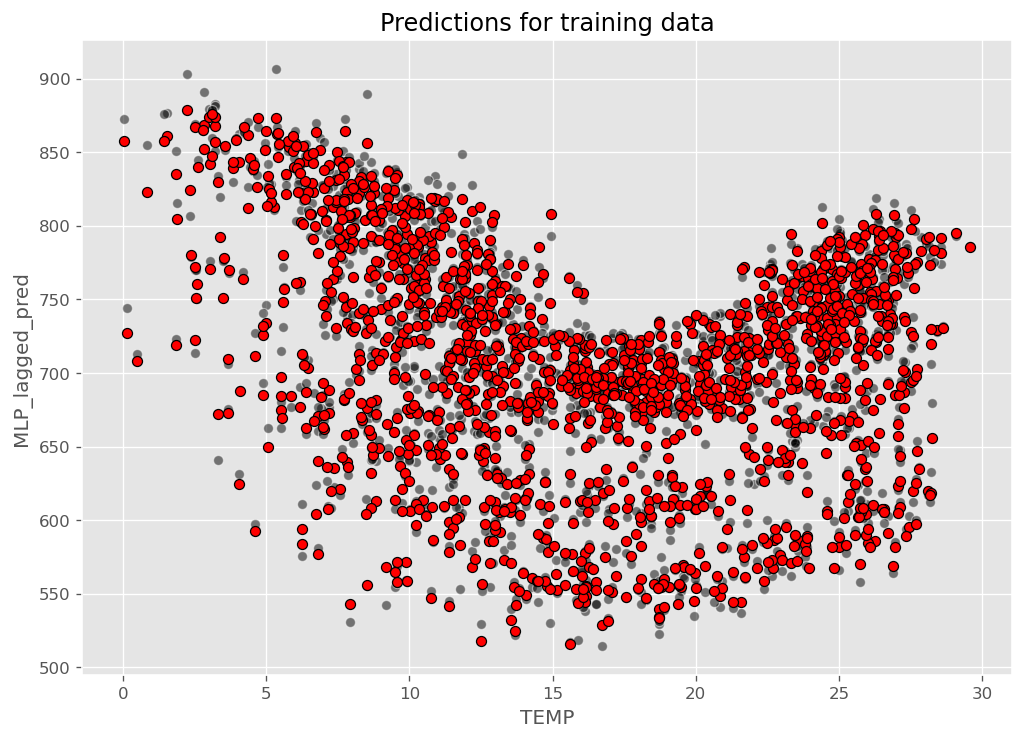

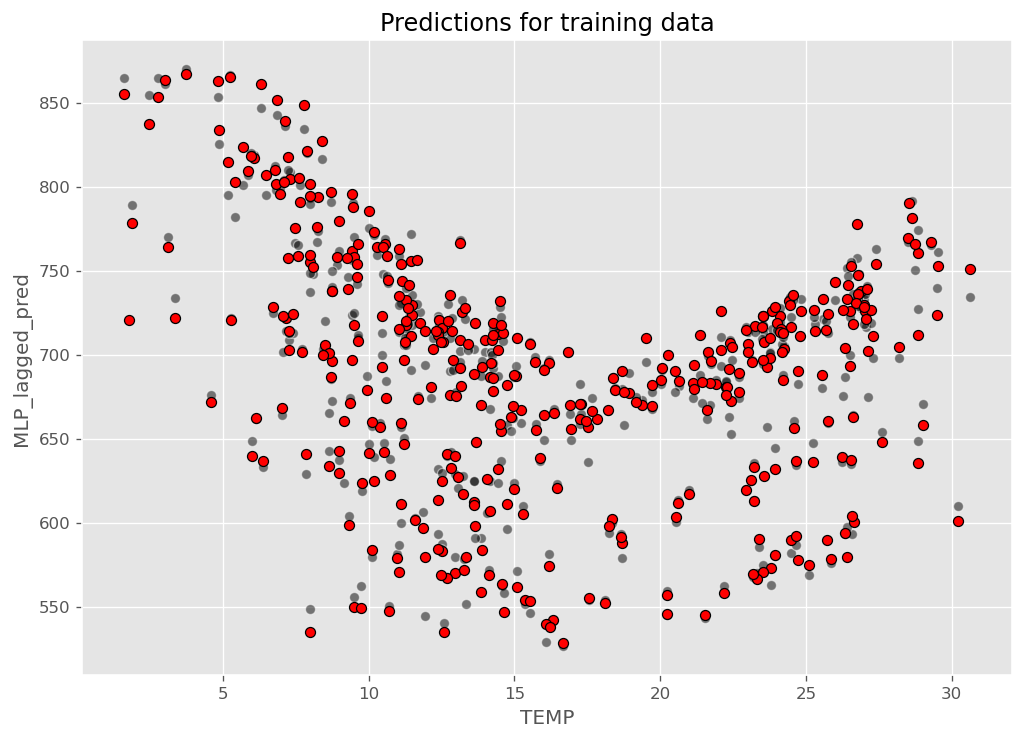

In [25]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_lagged_pred'] = MLP_lagged_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_lagged_pred'] = MLP_lagged_fit.predict(X_test)

### Plot predictions of the model
sns.scatterplot(x='TEMP', y='DEM', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_lagged_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TEMP', y='DEM', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_lagged_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

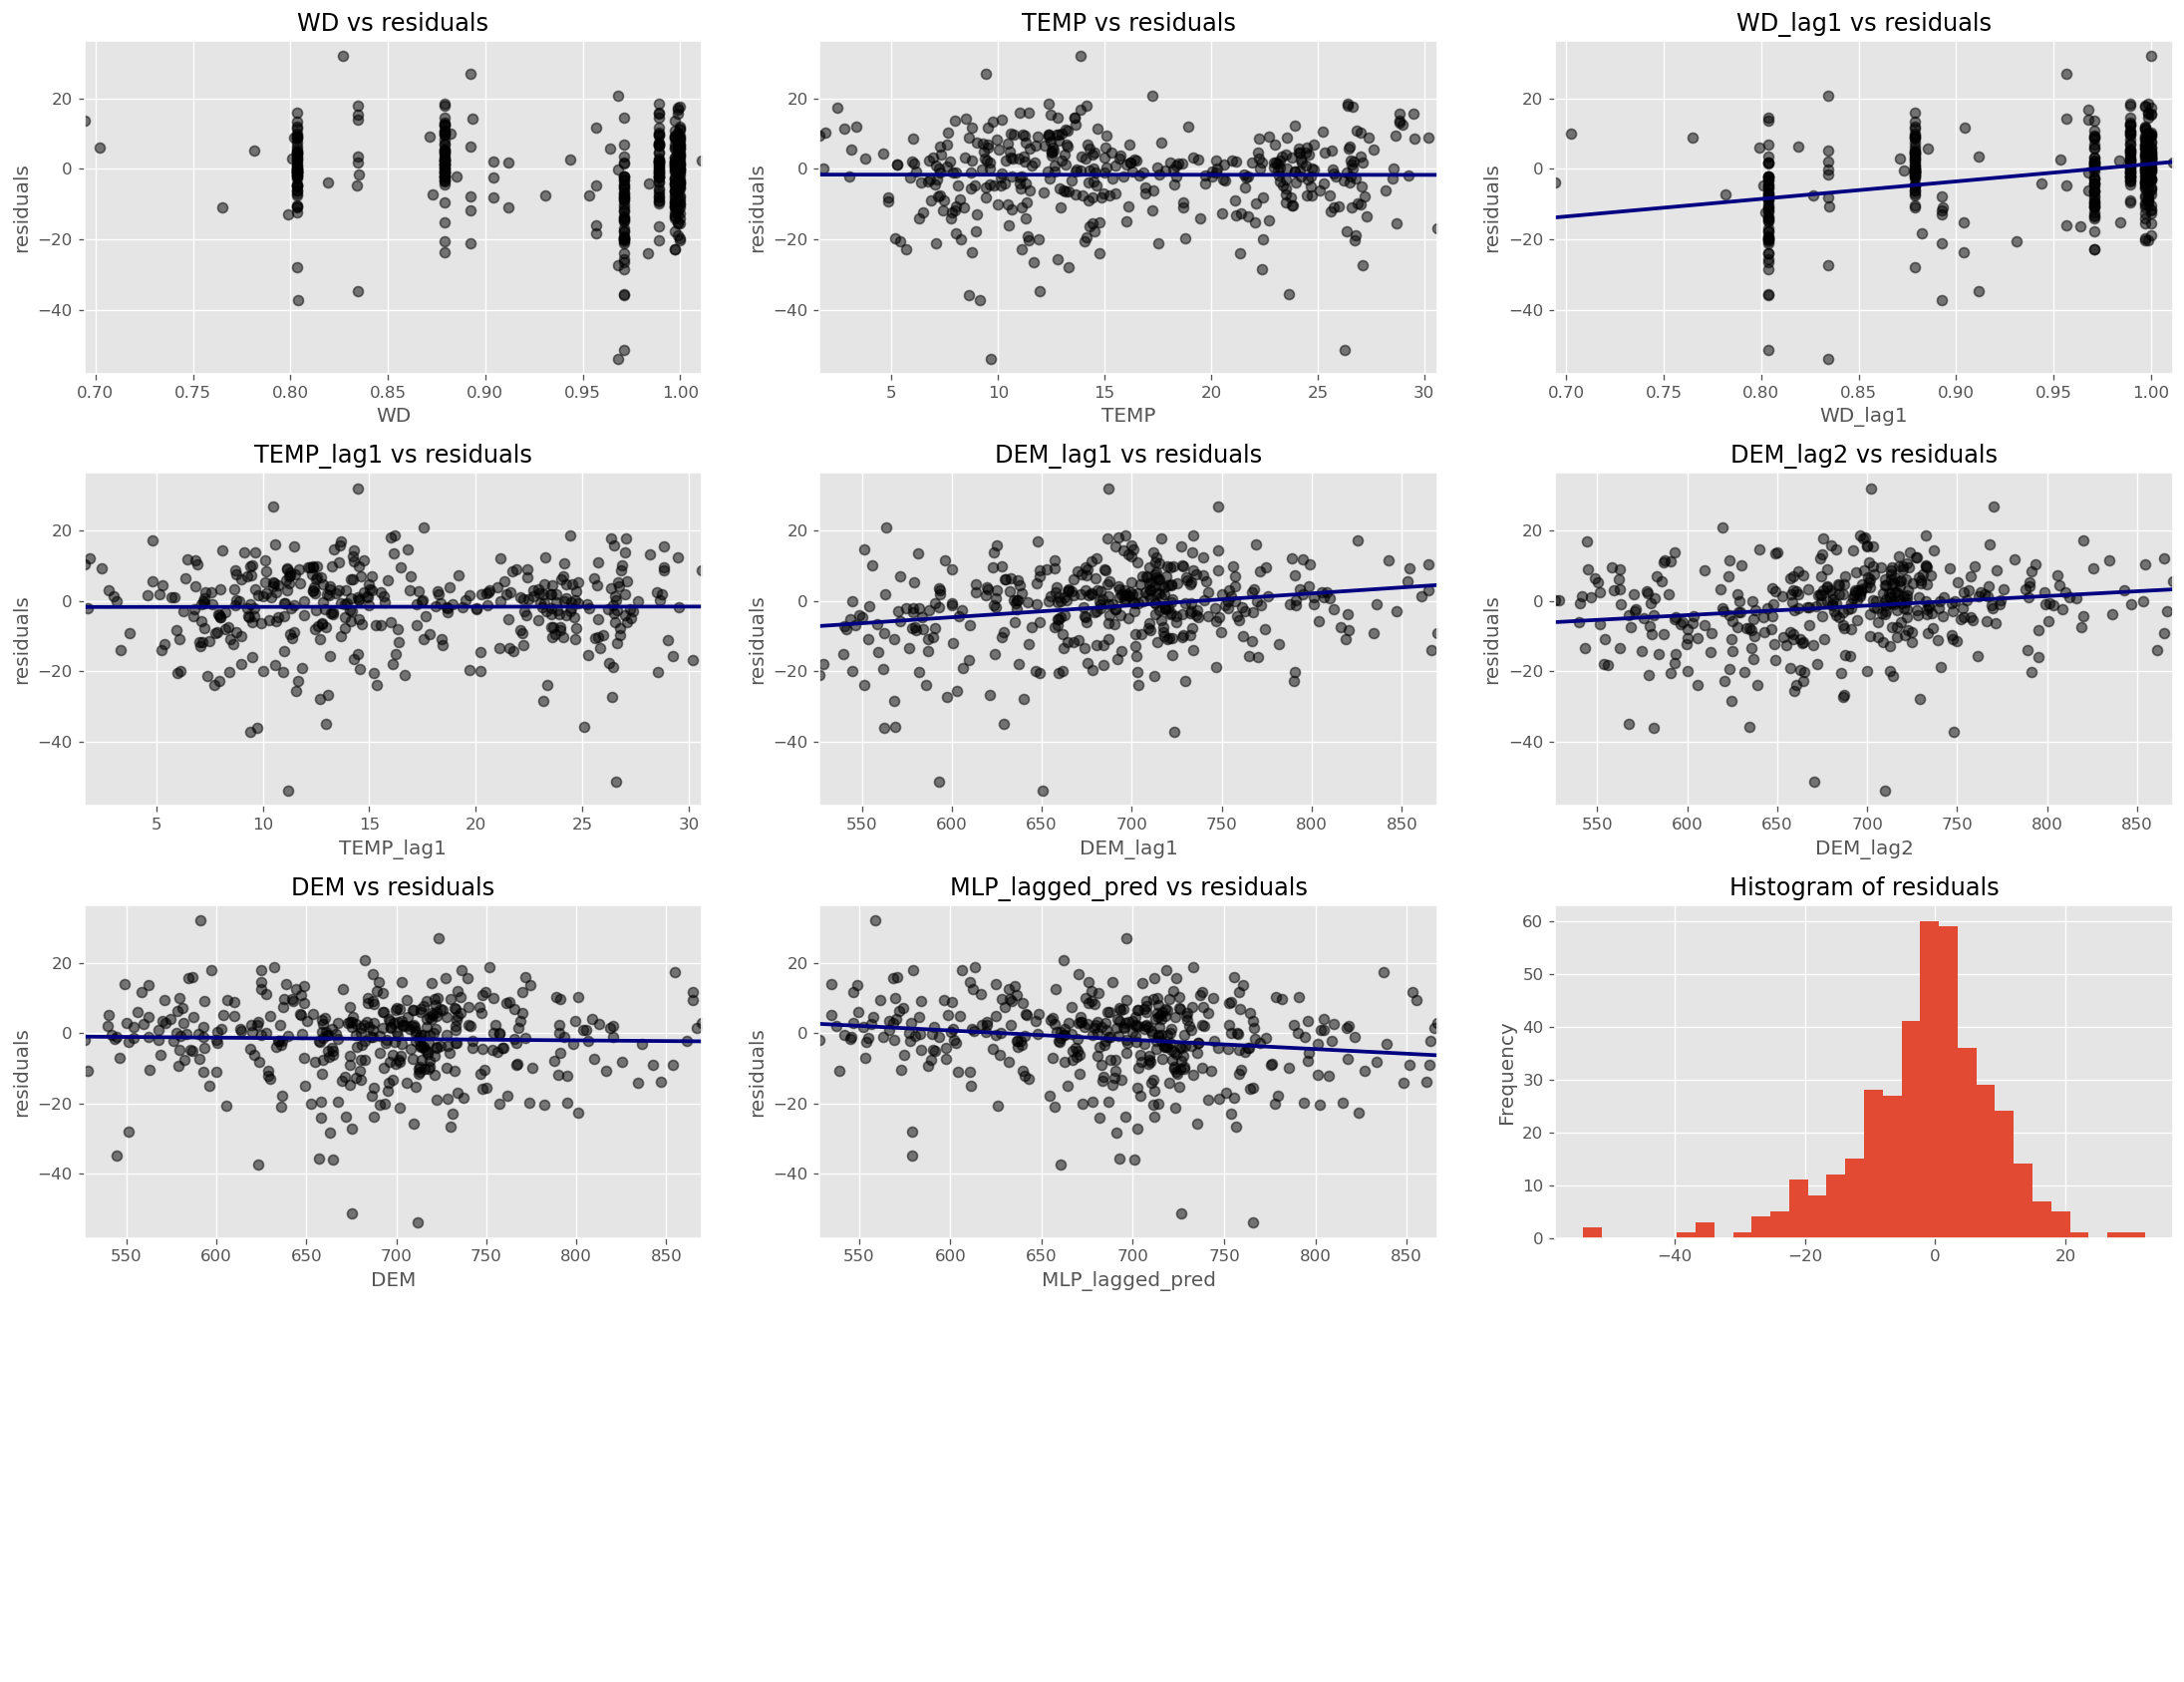

In [26]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTS_eval, 'MLP_lagged_pred', 'DEM', spline_degree=1)

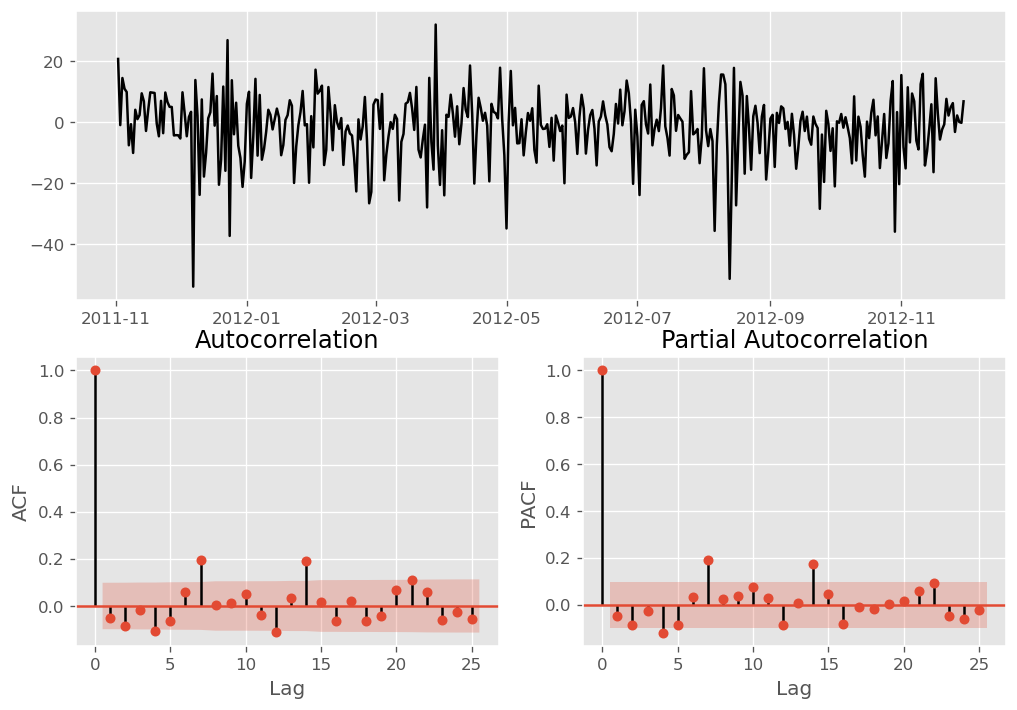

In [27]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['DEM'] - dfTS_eval['MLP_lagged_pred'])